# Tree Methods Consulting Project 

## Project detail:

A dog food company wants to predict why some batches of their dog food are spoiling much quicker than intended! Unfortunately this Dog Food company hasn't upgraded to the latest machinery, meaning that the amounts of the five preservative chemicals they are using can vary a lot, but which is the chemical that has the strongest effect? The dog food company first mixes up a batch of preservative that contains 4 different preservative chemicals (A,B,C,D) and then is completed with a "filler" chemical. The food scientists believe one of the A,B,C, or D preservatives is causing the problem, but need help to figure out which one!
Use Machine Learning with RF to find out which parameter had the most predicitive power, thus finding out which chemical causes the early spoiling! So create a model and then find out how you can decide which chemical is the problem!

* Pres_A : Percentage of preservative A in the mix
* Pres_B : Percentage of preservative B in the mix
* Pres_C : Percentage of preservative C in the mix
* Pres_D : Percentage of preservative D in the mix
* Spoiled: Label indicating whether or not the dog food batch was spoiled.


## Feature importance:

In this project, we use 3 different available tree classifiers in MLlib:

A single decision tree (DT)

A random forest (RF)

A gradient boosted tree (GBT) 

These classification approaches can be trained on a dataset and provide the **feature importance**. Feature importance reveals which variables are important, therefore can help us in early detection or even improving our product/service.

The **.featureImportances** function is implemented in DecisionTreeClassifier, RandomForestClassifier, and GBTClassifier.

### How the featureImportances is calculated:

According to the Pyspark MLlib Documentation:

#### Decision Tree:

This feature importance is calculated as follows:
          - importance(feature j) = sum (over nodes which split on feature j) of the gain,
            where gain is scaled by the number of instances passing through node
          - Normalize importances for tree to sum to 1.

**NB.** Feature importance for a single decision trees can have high variance due to correlated predictor variables. Consider using a RandomForestClassifier to determine feature importance instead.

#### Random forest and GBT: 

        - Each feature's importance is the average of its importance across all trees in the ensemble
        - The importance vector is normalized to sum to 1. 
        
        
### Hyperparameters:

Here, two important hyperparameters are explained.

**Maximum depth**: It simply limits the number of levels in the decision tree. It is the maximum number of chained decisions that the classifier will make to classify an example. It is useful to limit this to avoid overfitting the training data.

**Maximum bins**: The decision tree algorithm is responsible for coming up with potential decision rules to try at each level, like the 'A' >= 50 or 'A' >= 10 decisions. Decisions are always of the same form: for numeric features, decisions are of the form feature >= value; and for categorical features, they are of the form feature in (value1, value2, …). So, the set of decision rules to try is really a set of values to plug in to the decision rule. These are referred to as “bins” in the Spark MLlib implementation. A larger number of bins requires more processing time but might lead to finding a more optimal decision rule.

## Feature selection:

Once the feature importances are extracted, the columns with feature importance of less than a threshold can be dropped. Other feature selection strategies like Forward, backward, or stepwise method

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MLlibTreeProject').getOrCreate()

In [2]:
data = spark.read.csv('dog_food.csv', inferSchema=True, header=True)

In [3]:
data.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



In [4]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|                 A|                 B|                 C|                 D|            Spoiled|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               490|               490|               490|               490|                490|
|   mean|  5.53469387755102| 5.504081632653061| 9.126530612244897| 5.579591836734694| 0.2857142857142857|
| stddev|2.9515204234399057|2.8537966089662063|2.0555451971054275|2.8548369309982857|0.45221563164613465|
|    min|                 1|                 1|               5.0|                 1|                0.0|
|    max|                10|                10|              14.0|                10|                1.0|
+-------+------------------+------------------+------------------+------------------+-------------------+



In [5]:
#Count null/nan values for all columns:
from pyspark.sql.functions import isnan, isnull, when, count, col

data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+---+---+---+---+-------+
|  A|  B|  C|  D|Spoiled|
+---+---+---+---+-------+
|  0|  0|  0|  0|      0|
+---+---+---+---+-------+

+---+---+---+---+-------+
|  A|  B|  C|  D|Spoiled|
+---+---+---+---+-------+
|  0|  0|  0|  0|      0|
+---+---+---+---+-------+



In [6]:
data.show()


+---+---+----+---+-------+
|  A|  B|   C|  D|Spoiled|
+---+---+----+---+-------+
|  4|  2|12.0|  3|    1.0|
|  5|  6|12.0|  7|    1.0|
|  6|  2|13.0|  6|    1.0|
|  4|  2|12.0|  1|    1.0|
|  4|  2|12.0|  3|    1.0|
| 10|  3|13.0|  9|    1.0|
|  8|  5|14.0|  5|    1.0|
|  5|  8|12.0|  8|    1.0|
|  6|  5|12.0|  9|    1.0|
|  3|  3|12.0|  1|    1.0|
|  9|  8|11.0|  3|    1.0|
|  1| 10|12.0|  3|    1.0|
|  1|  5|13.0| 10|    1.0|
|  2| 10|12.0|  6|    1.0|
|  1| 10|11.0|  4|    1.0|
|  5|  3|12.0|  2|    1.0|
|  4|  9|11.0|  8|    1.0|
|  5|  1|11.0|  1|    1.0|
|  4|  9|12.0| 10|    1.0|
|  5|  8|10.0|  9|    1.0|
+---+---+----+---+-------+
only showing top 20 rows



In [7]:
data.count()

490

In [8]:
# count the values
data.groupby('Spoiled').count().show()

+-------+-----+
|Spoiled|count|
+-------+-----+
|    0.0|  350|
|    1.0|  140|
+-------+-----+



In [9]:
from pyspark.ml.feature import VectorAssembler
featureList = ['A','B','C','D']
assembler = VectorAssembler(inputCols = featureList,
                            outputCol = 'features')
df = assembler.transform(data).withColumnRenamed('Spoiled', 'label')

In [10]:
from pyspark.ml.classification import DecisionTreeClassifier,\
                                RandomForestClassifier, GBTClassifier

In [11]:
dt_classifier = DecisionTreeClassifier(featuresCol='features',labelCol='label')
rf_classifier = RandomForestClassifier(featuresCol='features',labelCol='label')
gbt_classifier = GBTClassifier(featuresCol='features',labelCol='label')

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [13]:
dt_paramGrid = ParamGridBuilder() \
    .addGrid(dt_classifier.maxDepth, [5, 10])\
    .addGrid(dt_classifier.maxBins, [20, 60])\
    .build()


rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.maxDepth, [5, 10])\
    .addGrid(rf_classifier.numTrees, [10, 20])\
    .addGrid(rf_classifier.maxBins, [20, 60])\
    .build()


gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth, [5, 10])\
    .addGrid(gbt_classifier.maxBins, [20, 60])\
    .build()

In [14]:

dt_crossval = CrossValidator(estimator=dt_classifier,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

rf_crossval = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

gbt_crossval = CrossValidator(estimator=gbt_classifier,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [15]:
dt_model = dt_crossval.fit(df)
dt_model.bestModel.featureImportances

SparseVector(4, {0: 0.0152, 1: 0.0137, 2: 0.9327, 3: 0.0384})

In [16]:
rf_model = rf_crossval.fit(df)
rf_model.bestModel.featureImportances

SparseVector(4, {0: 0.0377, 1: 0.0287, 2: 0.9027, 3: 0.0309})

In [17]:
gbt_model = gbt_crossval.fit(df)
gbt_model.bestModel.featureImportances

SparseVector(4, {0: 0.0296, 1: 0.0383, 2: 0.8286, 3: 0.1034})

Feature at index 2 (Chemical C) is the most important feature and causing the early spoilage! 

<BarContainer object of 4 artists>

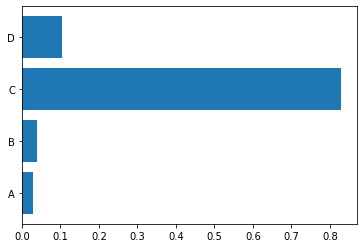

In [18]:
import matplotlib.pyplot as plt
plt.barh(featureList , gbt_model.bestModel.featureImportances)